###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):**     `PLEASE ENTER YOUR ID(S) HERE`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [15]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split

def preprocess(data):
    data = pd.read_csv(data)
    data = data.drop(["filename"], axis = 1)
    return data

In [16]:
# This function should calculat prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(data):
    
    n = len(data)
    prior_prob = []
    labels = data.values[:,-1]
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    #calculating prior probabilities
    for i in range(len(unique_labels)):
        prior_prob.insert(i, (counts[i] / n).round(2))
    
    unique_labels = np.unique(data.values[:,-1])
    unique_labels = list(unique_labels)
    
    features_list = list(data.columns)
    features_list.remove('label')
    
    mean = [ [] for i in range(len(unique_labels)) ]
    variance = [ [] for i in range(len(unique_labels)) ]
    
    for feature in features_list:
        for label in unique_labels:
            feature_values = data[feature].loc[data['label'] == label]
            mean[unique_labels.index(label)].insert(features_list.index(feature), np.mean(feature_values))
            variance[unique_labels.index(label)].insert(features_list.index(feature), np.var(feature_values))
    
    mean_var = []
    for i in range(len(mean)):
        mean_row = mean[i]
        var_row = variance[i]
        for n, value in enumerate(mean_row):
            mean_val = value
            var_val = var_row[n]
            mean_var.append([mean_val, var_val])
    
    mean_var = np.array(mean_var)   
    mean_var = np.vsplit(mean_var, len(unique_labels))
    
    return unique_labels, prior_prob, mean_var

In [18]:
# This function should predict classes for new items in a test dataset

def predict(test_data, labels, priors, parameters):
    
    test_data = test_data.drop(['label'], axis=1)
    def normal_dist(x, mean, var):
        exponent = math.exp(-((x - mean) ** 2 / (2 * var)))
        return (1 / (math.sqrt(2 * math.pi) * math.sqrt(var))) * exponent
    
    epsilon = 0.001
    predicted_labels = []
    for index, instance in test_data.iterrows():
        instance = list(instance[:-1])
        class_probabilities = []
        for i in range(len(labels)):
            probabilities = []
            for n in range(len(instance)):
                prob = normal_dist(instance[n], parameters[i][n][0], parameters[i][n][1])
                if math.isnan(instance[n]) == True:
                    continue                  
                if prob == 0:
                    prob = epsilon
                probabilities.insert(n, np.log(prob))
            probability = sum(probabilities)
            probability = np.log(priors[i]) + probability
            class_probabilities.insert(i, probability)
            
        predicted_labels.insert(index, labels[class_probabilities.index(max(class_probabilities))])

    return predicted_labels

labels, priors, parameters = train(preprocess("pop_vs_classical_train.csv"))
predicted_labels = predict(preprocess("pop_vs_classical_test.csv"), labels, priors, parameters)
predicted_labels

['classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'classical',
 'pop',
 'pop',
 'classical',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop',
 'pop']

In [19]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(predicted_labels, test_data, positive_class):
    truth_labels = list(test_data.values[:,-1])
    
    if positive_class is not None: 
        sk_accuracy = accuracy_score(truth_labels, predicted_labels)
        sk_precision = precision_score(truth_labels, predicted_labels, pos_label = positive_class)
        sk_recall = recall_score(truth_labels, predicted_labels, pos_label = positive_class)
        
    else:
        sk_accuracy = accuracy_score(truth_labels, predicted_labels)
        sk_precision = precision_score(truth_labels, predicted_labels, average = None, zero_division = 0)
        sk_recall = recall_score(truth_labels, predicted_labels, average = None, zero_division = 0)
    
    return sk_accuracy, sk_precision, sk_recall


## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

In [20]:
evaluate(predicted_labels, preprocess("pop_vs_classical_test.csv"), "classical")

(0.9767441860465116, 0.9523809523809523, 1.0)

### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

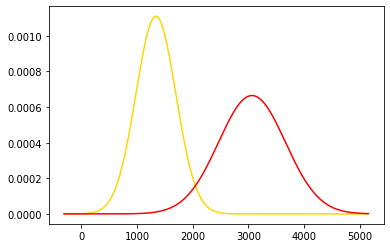

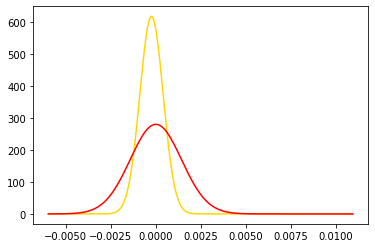

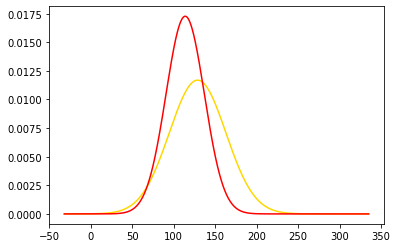

In [21]:
data = preprocess("pop_vs_classical_train.csv")
features_list = list(data.columns)
features_list.remove('label')

labels, priors, mean_var = train(data)
select_meanvar = []

for i in range(len(features_list)):
    if features_list[i] in {'spectral_centroid_mean', 'harmony_mean', 'tempo'}:
        select_meanvar.append([features_list[i], mean_var[0][i][0], math.sqrt(mean_var[0][i][1]), mean_var[1][i][0], math.sqrt(mean_var[1][i][1])])

'''plt.figure(figsize=(6, 9))
fig, (x, y, z) = plt.subplots(3,1)'''


x = np.arange(min(data['spectral_centroid_mean'])-1000, max(data['spectral_centroid_mean'])+1000, 0.001)
plt.plot(x, norm.pdf(x, select_meanvar[0][1], select_meanvar[0][2]), label='spectral_centroid_mean, classical', color='gold')
plt.plot(x, norm.pdf(x, select_meanvar[0][3], select_meanvar[0][4]), label='spectral_centroid_mean, pop', color='red')
plt.show()

y = np.arange(min(data['harmony_mean'])-0.002, max(data['harmony_mean']), 0.0001)
plt.plot(y, norm.pdf(y, select_meanvar[1][1], select_meanvar[1][2]), label='harmony_mean, classical', color='gold')
plt.plot(y, norm.pdf(y, select_meanvar[1][3], select_meanvar[1][4]), label='harmony_mean, pop', color='red')
plt.show()

z = np.arange(min(data['tempo'])-100, max(data['tempo'])+100, 0.001)
plt.plot(z, norm.pdf(z, select_meanvar[2][1], select_meanvar[2][2]), label='tempo, classical', color='gold')
plt.plot(z, norm.pdf(z, select_meanvar[2][3], select_meanvar[2][4]), label='tempo, pop', color='red')
plt.show()

## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

In [22]:
gztan_labels, gztan_priors, gztan_parameters = train(preprocess("gztan_train.csv"))

gztan_predicted_labels = predict(preprocess("gztan_test.csv"), gztan_labels, gztan_priors, gztan_parameters)

gztan_metrics = evaluate(gztan_predicted_labels, preprocess("gztan_test.csv"), positive_class = None)
gztan_metrics

(0.49,
 array([0.5       , 0.89473684, 0.39285714, 0.42857143, 0.46153846,
        0.5       , 0.36734694, 0.8       , 0.53333333, 0.2       ]),
 array([0.21052632, 0.85      , 0.6875    , 0.40909091, 0.28571429,
        0.33333333, 0.9       , 0.69565217, 0.57142857, 0.11111111]))

### Q3
Compare the performance of the full model to a 0R baseline and a one-attribute baseline. The one-attribute baseline should be the best possible naive Bayes model which uses only a prior and a single attribute. In your write-up, explain how you implemented the 0R and one-attribute baselines.

In [10]:
from sklearn.dummy import DummyClassifier
from collections import Counter

train_data = preprocess("gztan_train.csv")
test_data = preprocess("gztan_test.csv")

X = train_data.rms_mean
y = train_data.label

most_frq_clf = DummyClassifier(strategy='most_frequent')
most_frq_clf.fit(X, y)
accuracies = []
num_runs = 30
for i in range(num_runs):
    acc = most_frq_clf.score(X, y)
    accuracies.append(acc)
print(accuracies)
print('Average accuracy over {} runs is: {}.'.format(num_runs, np.mean(accuracies)))

train_data_spectral_centroid_var = train_data[['spectral_centroid_var', 'label']]
test_data_spectral_centroid_var = test_data[['spectral_centroid_var', 'label']]

oner_labels, oner_priors, oner_parameters = train(train_data_rms_mean)
predicted_labels = predict(test_data_rms_mean, oner_labels, oner_priors, oner_parameters)
acc = evaluate(predicted_labels, test_data_rms_mean, positive_class = None)[0]
print('Average accuracy is: {}.'.format(acc))


[0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075, 0.1075]
Average accuracy over 30 runs is: 0.10749999999999998.


NameError: name 'train_data_rms_mean' is not defined

### Q4
Train and test your model with a range of training set sizes by setting up your own train/test splits. With each split, use cross-fold validation so you can report the performance on the entire dataset (1000 items). You may use built-in functions to set up cross-validation splits. In your write-up, evaluate how model performance changes with training set size.

In [26]:
def cross_validate(k_vector, data):
    accuracies = [ [] for i in range(len(k_vector))]
    test_index_store = []
    
    for k in k_vector:
        kfold = KFold(k, shuffle = True, random_state = 1)
        for train_index, test_index in kfold.split(data):
            x_train = data.iloc[train_index, :]          
            x_test = data.iloc[test_index, :]
            x_labels, x_priors, x_parameters = train(x_train)
            xtest_predicted_labels = predict(x_test, x_labels, x_priors, x_parameters)
            xtest_metrics = evaluate(xtest_predicted_labels, x_test, positive_class = None)
            accuracies[k_vector.index(k)].append(xtest_metrics[0])
               
    mean_accuracies = []
    for i in range(len(accuracies)):
        mean_accuracies.append(np.mean(accuracies[i]))

    return mean_accuracies


test_data = preprocess("gztan_test.csv")
train_data = preprocess("gztan_train.csv")
k_data = test_data.append(train_data)
k_data = k_data.sample(frac=1).reset_index(drop=True)
k_values = [5, 10, 20, 50]

cross_validate(k_values, k_data)


# num_runs = 3
# sum_accuracy = [0 for k in k_values]
# for i in range(num_runs):
#     for k in k_values:
#         sum_accuracy[k_values.index(k)] += cross_validate(k_values, k_data)[k_values.index(k)]
        

# avg_accuracy = [sum_acc/num_runs for sum_acc in sum_accuracy]
# print(avg_accuracy)
    
    


[0.537, 0.526, 0.5309999999999999, 0.529]

### Q5
Implement a kernel density estimate (KDE) naive Bayes model and compare its performance to your Gaussian naive Bayes model. You may use built-in functions and automatic ("rule of thumb") bandwidth selectors to compute the KDE probabilities, but you should implement the naive Bayes logic yourself. You should give the parameters of the KDE implementation (namely, what bandwidth(s) you used and how they were chosen) in your write-up.

### Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.

In [73]:
labels, priors, parameters = train(preprocess("gztan_train.csv"))
test_data = preprocess("gztan_test.csv")

p = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.5]
accuracy_scores = [ [] for proportion in p]

for proportion in p:
    for i in range(5):
        for col in test_data.columns:
            test_data.loc[test_data.sample(frac = proportion).index, col] = np.nan
        gztan_predicted_labels_missing = predict(test_data)
        gztan_metrics_missing = evaluate(gztan_predicted_labels_missing, test_data, positive_class = None)
        accuracy_scores[p.index(proportion)].append(gztan_metrics_missing[0])
        test_data = preprocess("gztan_test.csv")
    

mean_scores = [np.mean(score_list) for score_list in accuracy_scores]
mean_scores

[0.49000000000000005,
 0.484,
 0.477,
 0.47000000000000003,
 0.437,
 0.388,
 0.299,
 0.24]